In [1]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy, get_spacy_model, train, predict, predict_with_threshold

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [2]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)


model = get_spacy_model(labels)

model = train(model, X_train, y_train, 10, test=(X_test, y_test))
model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 17.017993893983657 test score:35.528100553031024%
Iteration 1/10. train_loss: 1.121766613687214 test score:55.528260449020316%
Iteration 2/10. train_loss: 0.25368638884538086 test score:62.36539701968231%
Iteration 3/10. train_loss: 0.08899904541613068 test score:65.83247990404763%
Iteration 4/10. train_loss: 0.042284407436454785 test score:69.8450516985752%
Iteration 5/10. train_loss: 0.030522114562700153 test score:75.64185433113491%
Iteration 6/10. train_loss: 0.025341806256619748 test score:74.02135819299285%
Iteration 7/10. train_loss: 0.021943712858956133 test score:74.2022119925312%
Iteration 8/10. train_loss: 0.017325794777207193 test score:75.63915434571477%
Iteration 9/10. train_loss: 0.01592108074396492 test score:76.06655776175485%


In [3]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [4]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [5]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.78      0.54      0.64        67
      find-flight       0.74      0.96      0.84        24
       find-hotel       0.64      0.78      0.70        55
  find-restaurant       0.83      0.76      0.79        93
       find-train       0.74      0.81      0.77        21
       irrelevant       0.88      0.90      0.89       677
provide-showtimes       0.69      0.79      0.73        14
         purchase       0.73      0.70      0.72       114

         accuracy                           0.83      1065
        macro avg       0.75      0.78      0.76      1065
     weighted avg       0.84      0.83      0.83      1065



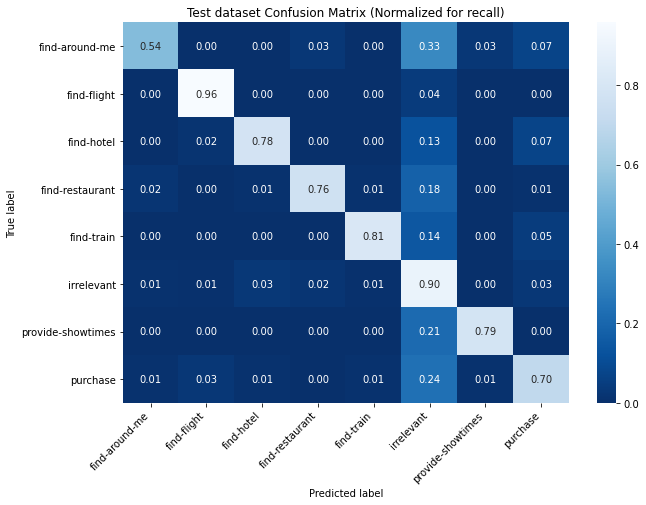

In [6]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

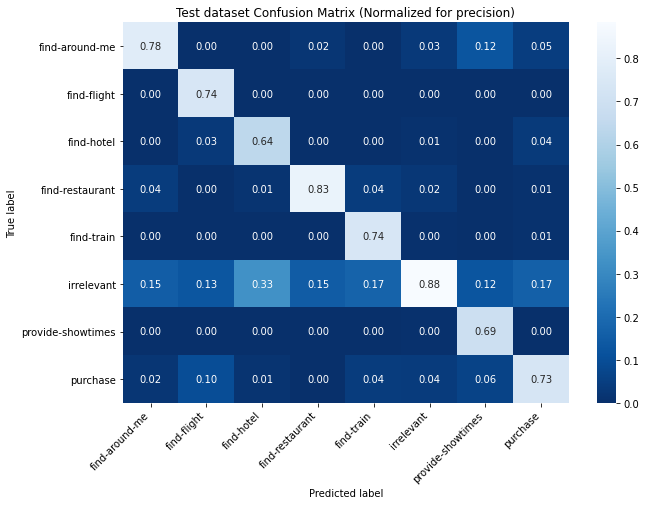

In [7]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On observe une précision presque identique au modèle d'origine néanmoins on remarquera que nous avons grandement amélioré le recall.
Cela nous intéresse puisque cette amélioration se traduit par une plus grande proportion d'intentions qui sont correctement décelées.
Les deux métriques tournent autour de 0.7-0.8 ce qui semble être un bon seuil d'utilisation afin d'avoir une expéreicne eutilisteur satisfaisante.
Plus concrètement, cela veut dire que l'utilisateur aura moins de frustration lorsqu'il tentera de lancer une action basée sur une intention, puisqu'auparavant il avait statistiquement 50% de chances que son intention soit reconnue, alors que maintenant il en a 70%.
Malgré tout, nous voulons faire en sorte d'essayer d'améliorer la précision qui reste un point déterminant de l'expérience utilisateur dans ce cas d'utilisation.
Pour y remédier, nous tentons alors de modifier notre prise de décision sur le retour du modèle en instaurant une fonction de seuil, qui introduit un pourcentage de certitude pour attribuer un label hors "irrelevant" au lieu de prendre la plus haute probabilité.

In [8]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.98      0.92      0.95       383
      find-flight       0.88      1.00      0.94       142
       find-hotel       0.95      0.98      0.97       316
  find-restaurant       0.97      0.98      0.98       469
       find-train       0.96      0.99      0.97       143
       irrelevant       0.99      0.98      0.99      3852
provide-showtimes       0.93      0.97      0.95       117
         purchase       0.95      0.97      0.96       613

         accuracy                           0.98      6035
        macro avg       0.95      0.97      0.96      6035
     weighted avg       0.98      0.98      0.98      6035



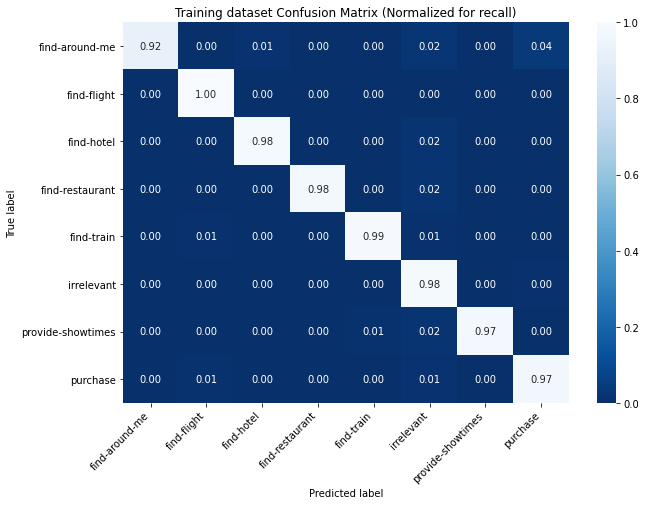

In [9]:
cm_testing_metrics = np.array(training_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Training dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [10]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.5, "irrelevant")
y_pred_t_thresh = predict_with_threshold(model, X_train, 0.5, "irrelevant")

In [11]:
training_results_thresh = score(y_true_t, y_pred_t_thresh)
testing_results_thresh = score(y_true, y_pred_thresh)

In [12]:
print(testing_results_thresh['report'])

                   precision    recall  f1-score   support

   find-around-me       0.82      0.54      0.65        67
      find-flight       0.82      0.96      0.88        24
       find-hotel       0.67      0.78      0.72        55
  find-restaurant       0.85      0.76      0.80        93
       find-train       0.73      0.76      0.74        21
       irrelevant       0.88      0.91      0.89       677
provide-showtimes       0.69      0.79      0.73        14
         purchase       0.74      0.69      0.71       114

         accuracy                           0.84      1065
        macro avg       0.77      0.77      0.77      1065
     weighted avg       0.84      0.84      0.84      1065



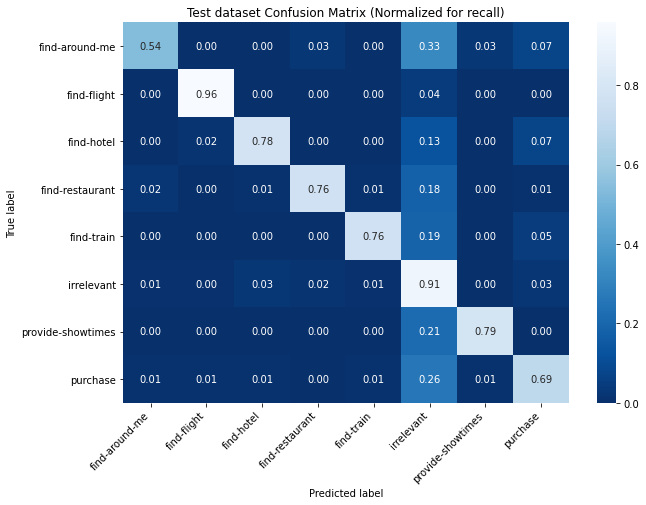

In [13]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

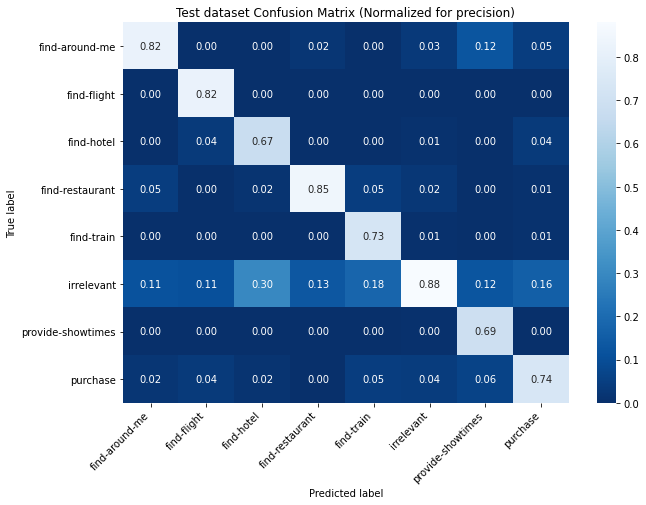

In [14]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

On remarque que lorsqu'on fixe un threshold assez faible, à 0.5, les résultats sont identiques, ce qui indique que notre modèle fait ses choix avec une confidence assez importante.

In [15]:
y_pred_thresh = predict_with_threshold(model, X_test, 0.75, "irrelevant")
y_pred_t_thresh = predict_with_threshold(model, X_train, 0.75, "irrelevant")
training_results_thresh = score(y_true_t, y_pred_t_thresh)
testing_results_thresh = score(y_true, y_pred_thresh)
print(testing_results_thresh['report'])

                   precision    recall  f1-score   support

   find-around-me       0.83      0.43      0.57        67
      find-flight       0.81      0.88      0.84        24
       find-hotel       0.76      0.75      0.75        55
  find-restaurant       0.89      0.75      0.81        93
       find-train       0.76      0.76      0.76        21
       irrelevant       0.85      0.93      0.89       677
provide-showtimes       0.73      0.79      0.76        14
         purchase       0.76      0.62      0.68       114

         accuracy                           0.84      1065
        macro avg       0.80      0.74      0.76      1065
     weighted avg       0.83      0.84      0.83      1065



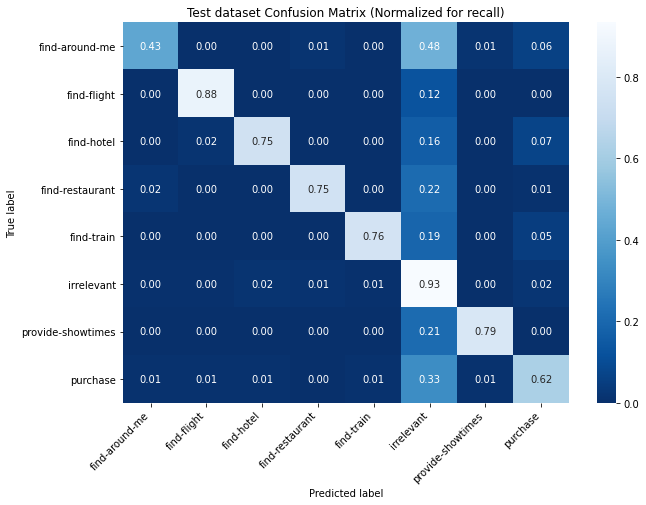

In [16]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

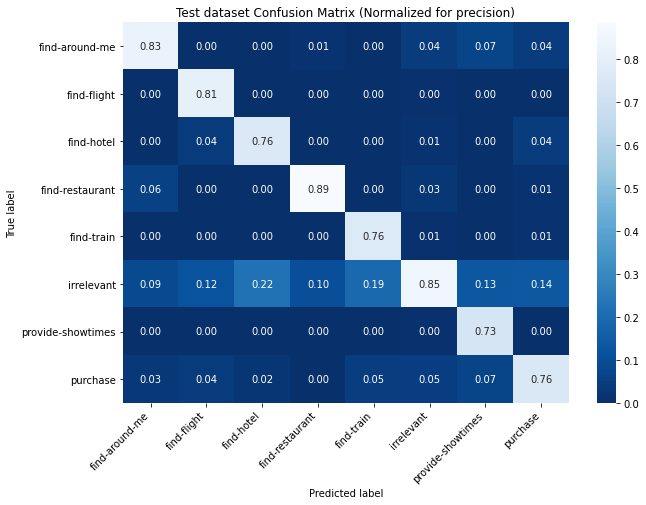

In [17]:
cm_testing_metrics = np.array(testing_results_thresh['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")

En essayant de monter le threshold à 0.75, on observe une légère amélioration de la précision sur l'ensemble des classes (hors 'irrelevant'), mais cette précision est contrebalancée par une diminution du recall. Nous préférons donc continuer avec le threshold à 0.5 .

# With the Augmented Training set

Le training set a été augmenté pour certaines classes, de nouveaux exemples sont produits à partir des anciens exemples.
Ces nouveaux exemples sont générés en remplaçant les mots de type 'verbe' et 'nom' par les lemmes de leurs synonymes.
Nous pensons que bien que cela nous ne offre pas de meilleures performances sur le training et le test set, si l'on arrive à garder les anciennnes performances, cela indiquera que ntore modèle est plus robuste.

In [26]:
raw_training_data = get_raw_training_data('./data/augmented_training_set.json')

for r in raw_training_data:
    if "message" in r:
        r["sentence"] = r["message"]

y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy(raw_training_data)

model = get_spacy_model(labels)

model = train(model, X_train, y_train, 18, test=(X_test, y_test))
model.to_disk(f"./model_augmented")

Training the model...
Iteration 0/18. train_loss: 20.58756566455122 test score:44.18682025909349%
Iteration 1/18. train_loss: 0.953205734025687 test score:64.51075386695163%
Iteration 2/18. train_loss: 0.18249770353759232 test score:68.99432100608793%
Iteration 3/18. train_loss: 0.05552501957208733 test score:72.81683127369863%
Iteration 4/18. train_loss: 0.03328413704184641 test score:74.76940018253987%
Iteration 5/18. train_loss: 0.02617205926708266 test score:75.11313167587664%
Iteration 6/18. train_loss: 0.021285510278175934 test score:74.57532595333191%
Iteration 7/18. train_loss: 0.01606597100703766 test score:76.84623029541557%
Iteration 8/18. train_loss: 0.014908567351767488 test score:76.82040749485182%
Iteration 9/18. train_loss: 0.013043093700446207 test score:76.55159652779466%
Iteration 10/18. train_loss: 0.010067116626292005 test score:75.24469085436827%
Iteration 11/18. train_loss: 0.008502545987589372 test score:74.98367236475316%
Iteration 12/18. train_loss: 0.00806946

In [10]:
y_pred = predict(model, X_test)
y_pred_t = predict(model, X_train)

In [11]:
training_results = score(y_true_t, y_pred_t)
testing_results = score(y_true, y_pred)

In [12]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.61      0.64      0.63        67
      find-flight       0.91      0.83      0.87        24
       find-hotel       0.83      0.69      0.75        55
  find-restaurant       0.86      0.77      0.81        93
       find-train       0.68      0.71      0.70        21
       irrelevant       0.89      0.92      0.90       677
provide-showtimes       0.73      0.79      0.76        14
         purchase       0.78      0.75      0.76       114

         accuracy                           0.85      1065
        macro avg       0.79      0.76      0.77      1065
     weighted avg       0.85      0.85      0.85      1065



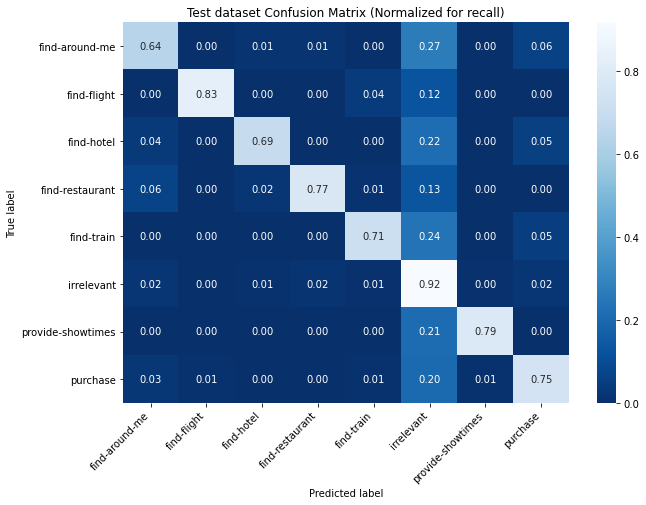

In [13]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [14]:
print(training_results['report'])

                   precision    recall  f1-score   support

   find-around-me       1.00      1.00      1.00       600
      find-flight       1.00      1.00      1.00       284
       find-hotel       1.00      1.00      1.00       500
  find-restaurant       1.00      1.00      1.00       700
       find-train       1.00      1.00      1.00       300
       irrelevant       1.00      1.00      1.00      3852
provide-showtimes       1.00      1.00      1.00       300
         purchase       1.00      1.00      1.00       800

         accuracy                           1.00      7336
        macro avg       1.00      1.00      1.00      7336
     weighted avg       1.00      1.00      1.00      7336

